In [194]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [195]:
### Import our Own CTRW Code 
import CTRW_base as CTRW
import CTRW2_mc
import CTRW4
%matplotlib inline

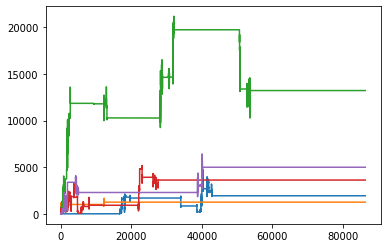

In [196]:
alpha = 0.5
D_coeff = 2.8e11  # nm^2/s
jump_t = 1e-12  # jump time in s
min_t = 0.001  # minimum waiting time in s
run_t = 86400  # simulation run time in s

nsamples = 100

for n in range(5):
    pos_df = CTRW.ctrw_3d((0,0,0), D_coeff, jump_t, run_t, min_t, alpha, plot=0)
    pos_df["r^2"] = pos_df["x"]**2 + pos_df["y"]**2 + pos_df["z"]**2
    plt.plot(pos_df["t"], pos_df["r^2"])

In [197]:
def get_msd_df(nsamples, tstep, D_coeff, jump_t, run_t, min_t, alpha):
    
    msd_ts = np.linspace(0, run_t, int(run_t/tstep)+1)
    
    msd_sqr_disps_arr = np.zeros([nsamples, len(msd_ts)])
    
    for n in range(nsamples):
        pos_df = CTRW.ctrw_3d((0,0,0), D_coeff, jump_t, run_t, min_t, alpha, plot=0)
        pos_df["r^2"] = pos_df["x"]**2 + pos_df["y"]**2 + pos_df["z"]**2
        
        sqr_disps = np.array([0])
        pos_df_r_sqr = np.array(pos_df['r^2'])

        for t in msd_ts[1:-1]:
            i = pos_df[pos_df['t'].gt(t)].index[0]
            sqr_disps = np.append(sqr_disps, pos_df_r_sqr[i])

        sqr_disps = np.append(sqr_disps, pos_df_r_sqr[-1])
        msd_sqr_disps_arr[n] = sqr_disps
        
    msd = np.mean(msd_sqr_disps_arr, axis=0)
    std_dev = np.std(msd_sqr_disps_arr, axis=0)
    std_error = std_dev/np.sqrt(nsamples)
    
    d = {"t": msd_ts, "msd": msd, "std_dev": std_dev, "std_error": std_error}
    msd_df = pd.DataFrame(data=d)
    
    return msd_df

In [198]:
nsamples = 100
tstep = 0.5
run_t = 2000 

In [200]:
#msd_df = get_msd_df(nsamples, tstep, D_coeff, jump_t, run_t, min_t, alpha)

In [201]:
msd_df = pd.read_csv('msd_df_full_run_t', index_col=0)

In [202]:
msd_df

,t,msd,std_dev,std_error
0,0.0,0.000000,0.000000,0.000000
1,100.0,342.333917,370.339071,37.033907
2,200.0,501.285787,527.373831,52.737383
3,300.0,639.544545,673.729765,67.372977
4,400.0,773.441729,874.883459,87.488346
...,...,...,...,...
860,86000.0,11055.556381,13160.805987,1316.080599
861,86100.0,11057.970292,13196.642868,1319.664287
862,86200.0,11097.167467,13220.577642,1322.057764
863,86300.0,11091.863038,13221.916019,1322.191602


In [275]:
def power_law(t, k, a):
    return k * np.power(t,a)

def chi_sqr(observed_data, observed_uncertainty, fitted_data):
    
    chi_sqr = 0
    for i in range(1, len(fitted_data)):
        chi_sqr += ((observed_data[i] - fitted_data[i])**2 / (observed_uncertainty[i])**2)

    return chi_sqr

In [276]:
msd_ts = np.linspace(0, run_t, int(run_t/100)+1)
popt, pcov = curve_fit(power_law, msd_df['t'][1:], msd_df['msd'][1:], sigma=msd_df['std_error'][1:], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))

Text(0.03, 0.75, '$k=40.3840\\pm1.7661$ nm$^2$\n$a=0.484\\pm0.004$\nreduced $\\chi^2=0.368$')

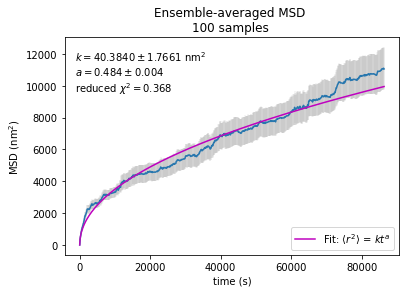

In [286]:
plt.errorbar(msd_df['t'], msd_df['msd'], yerr=msd_df['std_error'], color='gray', alpha=0.1)
plt.plot(msd_df['t'], msd_df['msd'])
plt.xlabel('time (s)')
plt.ylabel(r'MSD (nm$^2$)')
plt.title('Ensemble-averaged MSD \n100 samples '.format(nsamples, tstep))

fitted_data = power_law(msd_df['t'], *popt)

plt.plot(msd_df['t'], fitted_data, color='m', label=r'Fit: $\langle{r}^2\rangle$ = $kt^a$')
plt.legend(loc='lower right')

red_chi_sqr = chi_sqr(msd_df['msd'], msd_df['std_error'], fitted_data) / (len(fitted_data)-2)

plt.annotate(r'$k={:.4f}\pm{:.4f}$ nm$^2$'.format(popt[0],perr[0])+'\n'
             +r'$a={:.3f}\pm{:.3f}$'.format(popt[1],perr[1])+'\n'
             +r'reduced $\chi^2={:.3f}$'.format(red_chi_sqr),
             (0.03,0.75), xycoords='axes fraction')

In [148]:
#msd_df.to_csv('msd_df_run_t_2000')

In [165]:
def get_disp_df(nsamples, t_vals, D_coeff, jump_t, min_t, alpha):
    
    if t_vals[0]!=0:
        t_vals = np.append(0, t_vals)
    
    msd_ts = t_vals
    run_t = t_vals[-1]
    msd_sqr_disps_arr = np.zeros([nsamples, len(msd_ts)])
    
    for n in range(nsamples):
        pos_df = CTRW.ctrw_3d((0,0,0), D_coeff, jump_t, run_t, min_t, alpha, plot=0)
        pos_df["r^2"] = pos_df["x"]**2 + pos_df["y"]**2 + pos_df["z"]**2
        
        sqr_disps = np.array([0])
        pos_df_r_sqr = np.array(pos_df['r^2'])

        for t in msd_ts[1:-1]:
            i = pos_df[pos_df['t'].gt(t)].index[0]
            sqr_disps = np.append(sqr_disps, pos_df_r_sqr[i])

        sqr_disps = np.append(sqr_disps, pos_df_r_sqr[-1])
        msd_sqr_disps_arr[n] = sqr_disps
        
    msd = np.mean(msd_sqr_disps_arr, axis=0)
    std_dev = np.std(msd_sqr_disps_arr, axis=0)
    std_error = std_dev/np.sqrt(nsamples)
    
    disp = np.sqrt(msd)
    disp_error = disp * 0.5 * std_error/msd
    
    d = {"t": msd_ts, "msd": msd, "disp": disp, "disp_std_error": disp_error}
    disp_df = pd.DataFrame(data=d)
    
    return disp_df
    

In [166]:
t_vals = np.array([2.5,5,10,20,40,80,160,320,640,1280,2560])
disp_df = get_disp_df(nsamples, t_vals, D_coeff, jump_t, min_t, alpha)

C:\Users\4mila\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [167]:
disp_df

,t,msd,disp,disp_std_error
0,0.0,0.000000,0.000000,NaN
1,2.5,49.979748,7.069636,0.460209
2,5.0,65.271661,8.079088,0.573620
3,10.0,96.561117,9.826552,0.622182
4,20.0,143.669759,11.986232,0.779626
5,40.0,181.185168,13.460504,0.759684
6,80.0,271.713885,16.483746,1.035276
7,160.0,402.694725,20.067255,1.327815
8,320.0,599.986208,24.494616,1.451889
9,640.0,880.099168,29.666465,1.786661


In [175]:
def calculate_separation(coords1, coords2):
    
    x1, y1, z1 = coords1
    x2, y2, z2 = coords2
    sep = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
    return sep

def get_sep_df(nsamples, t_vals, D_coeff, jump_t, min_t, alpha):
    
    if t_vals[0]!=0:
        t_vals = np.append(0, t_vals)
    
    run_time = t_vals[-1]
    delay_t = run_time  # don't want any interactions
    
    sep_arr = np.zeros([nsamples, len(t_vals)])
    
    #msd_sqr_disps_arr = np.zeros([nsamples, len(msd_ts)])
    
    for n in range(nsamples):
        
        _, _, _, _, _, df1, df2 = CTRW.ctrw_3d_interaction([(0,0,0),(0,0,0)], D_coeff, jump_t, run_time, min_t, alpha, 25,
                                                           delay_t, interaction_p=1, plot=0, return_trajectories=True)
        
        x1 = np.array(df1['x'])
        y1 = np.array(df1['y'])
        z1 = np.array(df1['z'])
        
        x2 = np.array(df2['x'])
        y2 = np.array(df2['y'])
        z2 = np.array(df2['z'])
        
        seps = np.array([0])
        
        for t in t_vals[1:-1]:
            i1 = df1[df1['t'].gt(t)].index[0]
            i2 = df2[df2['t'].gt(t)].index[0]
            sep = calculate_separation((x1[i1], y1[i1], z1[i1]), (x2[i2], y2[i2], z2[i2]))
            seps = np.append(seps, sep)
            
        final_sep = calculate_separation((x1[-1], y1[-1], z1[-1]), (x2[-1], y2[-1], z2[-1]))
        seps = np.append(seps, final_sep)
        
        sep_arr[n] = seps
        
    mean_sep = np.mean(sep_arr, axis=0)
    sep_std_dev = np.std(sep_arr, axis=0)
    sep_std_error = sep_std_dev/np.sqrt(nsamples)
    
    d = {"t": t_vals, "mean_sep": mean_sep, "sep_std_dev": sep_std_dev, "sep_std_error": sep_std_error}
    sep_df = pd.DataFrame(data=d)
    
    return sep_df

In [181]:
nsamples = 500
sep_df = get_sep_df(nsamples, t_vals, D_coeff, jump_t, min_t, alpha)

In [182]:
sep_df

,t,mean_sep,sep_std_dev,sep_std_error
0,0.0,0.000000,0.000000,0.000000
1,2.5,8.929444,5.110571,0.228552
2,5.0,10.736809,5.651798,0.252756
3,10.0,13.044506,7.279262,0.325538
4,20.0,15.266063,8.760133,0.391765
5,40.0,18.238999,10.604552,0.474250
6,80.0,21.180224,11.792394,0.527372
7,160.0,25.031143,13.900708,0.621659
8,320.0,28.745573,16.749668,0.749068
9,640.0,33.233087,19.829696,0.886811


In [184]:
sep_df.to_csv('sep_df_500samples')